# Test simple RNN, LSTM and GRU models

### load data

In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow.keras as K

from lib.utils import read_data

2021-11-19 18:34:11.387143: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1


In [2]:
labels_by_punch_types = [
    ['id0_hook_1', 'id0_hook_2', 'id1_hook_1', 'id1_hook_2'],
    ['id0_jab_1', 'id0_jab_2', 'id1_jab_1', 'id1_jab_2'],
    ['id0_uper_1', 'id0_uper_2', 'id1_uper_1', 'id1_uper_2']
]

In [3]:
X_train_list = []
y_train_list = []
X_test_list = []
y_test_list = []

for labels in labels_by_punch_types:
    test_label = random.choice(labels)

    for label in [i for i in labels if i != test_label]:
        X, y = read_data(label)
        X_train_list.append(X)
        y_train_list.append(y)
    
    X, y = read_data(test_label)
    X_test_list.append(X)
    y_test_list.append(y)


X_train = np.concatenate(X_train_list)
y_train = np.concatenate(y_train_list)
X_test = np.concatenate(X_test_list)
y_test = np.concatenate(y_test_list)

(1051, 36)
(858, 36)
(792, 36)
(1100, 36)
(993, 36)
(802, 36)
(643, 36)
(952, 36)
(1200, 36)
(1186, 36)
(746, 36)
(703, 36)


In [4]:
TIME_STEPS = 30 # expect camera 30 fps, so process 1 sample per second

# Number of samples in batch
N_train = X_train.shape[0] // TIME_STEPS 
N_test = y_test.shape[0] // TIME_STEPS

X_train = X_train[:N_train * TIME_STEPS].reshape(-1, TIME_STEPS, 36)
y_train = y_train[:N_train * TIME_STEPS].reshape(-1, TIME_STEPS, 1)
X_test = X_test[:N_test * TIME_STEPS].reshape(-1, TIME_STEPS, 36)
y_test = y_test[:N_test * TIME_STEPS].reshape(-1, TIME_STEPS, 1)

In [5]:
y_train = K.utils.to_categorical(y_train, num_classes=7)
X_train = tf.constant(X_train)

y_test = K.utils.to_categorical(y_test, num_classes=7)
X_test = tf.constant(X_test)

2021-11-19 18:34:17.020304: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2021-11-19 18:34:17.133820: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:982] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-19 18:34:17.134678: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce GTX 1650 computeCapability: 7.5
coreClock: 1.515GHz coreCount: 14 deviceMemorySize: 3.82GiB deviceMemoryBandwidth: 178.84GiB/s
2021-11-19 18:34:17.134726: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2021-11-19 18:34:17.137580: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10
2021-11-19 18:34:17.141352: I tensorflow/stream_executor/pla

## Simple RNN 

In [7]:
def get_model():
    return K.Sequential([
        K.layers.InputLayer((30, 36), batch_size=1),
        K.layers.SimpleRNN(32, stateful=True, return_sequences=True),
        K.layers.Dense(64),
        K.layers.Dense(7, activation='softmax')
    ])

In [8]:
model = get_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (1, 30, 32)               2208      
_________________________________________________________________
dense (Dense)                (1, 30, 64)               2112      
_________________________________________________________________
dense_1 (Dense)              (1, 30, 7)                455       
Total params: 4,775
Trainable params: 4,775
Non-trainable params: 0
_________________________________________________________________


In [9]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [11]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=1, epochs=30)

Epoch 1/30
275/275 [==============================] - 9s 32ms/step - loss: 1.3600 - accuracy: 0.5662 - val_loss: 1.5248 - val_accuracy: 0.5026
Epoch 2/30
275/275 [==============================] - 11s 40ms/step - loss: 1.2210 - accuracy: 0.5801 - val_loss: 1.2539 - val_accuracy: 0.5315
Epoch 3/30
275/275 [==============================] - 11s 39ms/step - loss: 1.1107 - accuracy: 0.6062 - val_loss: 1.2333 - val_accuracy: 0.5832
Epoch 4/30
275/275 [==============================] - 10s 38ms/step - loss: 1.0538 - accuracy: 0.6210 - val_loss: 1.2106 - val_accuracy: 0.5813
Epoch 5/30
275/275 [==============================] - 10s 36ms/step - loss: 1.0289 - accuracy: 0.6184 - val_loss: 1.1893 - val_accuracy: 0.5978
Epoch 6/30
275/275 [==============================] - 10s 35ms/step - loss: 0.9858 - accuracy: 0.6398 - val_loss: 1.1675 - val_accuracy: 0.6095
Epoch 7/30
275/275 [==============================] - 9s 32ms/step - loss: 0.9565 - accuracy: 0.6530 - val_loss: 1.1530 - val_accuracy: 0

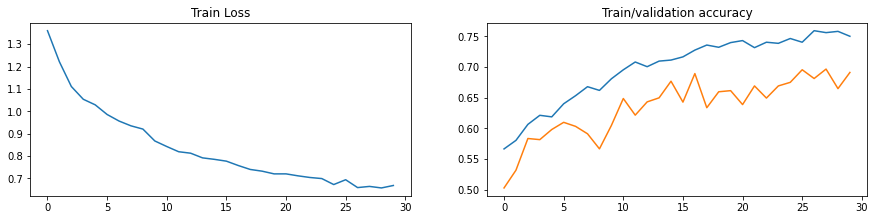

In [12]:
plt.figure(figsize=(15, 7))
plt.subplot(221)
plt.title("Train Loss")
plt.plot(history.history['loss'])
plt.subplot(222)
plt.title("Train/validation accuracy")
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

In [13]:
model.save('simple_rnn.h5')

## LSTM

In [15]:
def get_model():
    return K.Sequential([
        K.layers.InputLayer((30, 36), batch_size=1),
        K.layers.LSTM(64, return_sequences=True),
        K.layers.Dense(128, kernel_regularizer=tf.keras.regularizers.l2(l2=1e-3)),
        K.layers.Dense(7, activation='softmax')
    ])

In [16]:
model = get_model()
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (1, 30, 64)               25856     
_________________________________________________________________
dense_2 (Dense)              (1, 30, 128)              8320      
_________________________________________________________________
dense_3 (Dense)              (1, 30, 7)                903       
Total params: 35,079
Trainable params: 35,079
Non-trainable params: 0
_________________________________________________________________


In [19]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [20]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=1, epochs=30)

Epoch 1/30


2021-11-19 18:43:29.560698: E tensorflow/stream_executor/cuda/cuda_dnn.cc:328] Could not create cudnn handle: CUDNN_STATUS_INTERNAL_ERROR
2021-11-19 18:43:29.560808: W tensorflow/core/framework/op_kernel.cc:1767] OP_REQUIRES failed at cudnn_rnn_ops.cc:1510 : Unknown: Fail to find the dnn implementation.


UnknownError:    Fail to find the dnn implementation.
	 [[{{node CudnnRNN}}]]
	 [[sequential_1/lstm/PartitionedCall]] [Op:__inference_train_function_29573]

Function call stack:
train_function -> train_function -> train_function


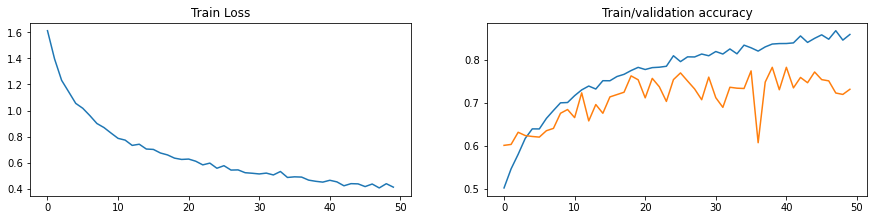

In [83]:
plt.figure(figsize=(15, 7))
plt.subplot(221)
plt.title("Train Loss")
plt.plot(history.history['loss'])
plt.subplot(222)
plt.title("Train/validation accuracy")
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

In [ ]:
model.save('lstm.h5')

## GRU

In [84]:
def get_model():
    return K.Sequential([
        K.layers.InputLayer((30, 36), batch_size=1),
        K.layers.GRU(64, return_sequences=True),
        K.layers.Dense(128, kernel_regularizer=tf.keras.regularizers.l2(l2=1e-3)),
        K.layers.Dropout(0.2),
        K.layers.Dense(7, activation='softmax')
    ])

In [85]:
model = get_model()
model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (1, 30, 64)               19584     
_________________________________________________________________
dense_20 (Dense)             (1, 30, 128)              8320      
_________________________________________________________________
dropout_4 (Dropout)          (1, 30, 128)              0         
_________________________________________________________________
dense_21 (Dense)             (1, 30, 7)                903       
Total params: 28,807
Trainable params: 28,807
Non-trainable params: 0
_________________________________________________________________


In [86]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [88]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=1, epochs=50)

Epoch 1/50
274/274 [==============================] - 5s 17ms/step - loss: 1.5822 - accuracy: 0.5116 - val_loss: 1.2769 - val_accuracy: 0.6080
Epoch 2/50
274/274 [==============================] - 4s 13ms/step - loss: 1.3599 - accuracy: 0.5472 - val_loss: 1.0940 - val_accuracy: 0.6388
Epoch 3/50
274/274 [==============================] - 4s 13ms/step - loss: 1.1927 - accuracy: 0.5955 - val_loss: 1.1745 - val_accuracy: 0.6040
Epoch 4/50
274/274 [==============================] - 4s 13ms/step - loss: 1.0961 - accuracy: 0.6248 - val_loss: 0.8852 - val_accuracy: 0.6721
Epoch 5/50
274/274 [==============================] - 4s 14ms/step - loss: 1.0021 - accuracy: 0.6611 - val_loss: 0.9399 - val_accuracy: 0.6750
Epoch 6/50
274/274 [==============================] - 4s 13ms/step - loss: 0.9408 - accuracy: 0.6766 - val_loss: 0.8506 - val_accuracy: 0.6812
Epoch 7/50
274/274 [==============================] - 4s 13ms/step - loss: 0.8785 - accuracy: 0.6906 - val_loss: 0.8251 - val_accuracy: 0.7304

In [ ]:
plt.figure(figsize=(15, 7))
plt.subplot(221)
plt.title("Train Loss")
plt.plot(history.history['loss'])
plt.subplot(222)
plt.title("Train/validation accuracy")
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

In [ ]:
model.save('gru.h5')